In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
import os
import shutil
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


# The images were placed in four folders depending on if they were for testing
# or training and if they contained a bat. The images were split 15% testing
# and 85% training
train_bat = "bat_train"
train_no_bat= "no_bat_train"
test_bat= "bat_test"
test_no_bat= "no_bat_test"

In [3]:
# All images were resized to 150 X 150. This can be changed depending on how much RAM is available
image_size = 150

# Converts training images to numpy arrays and preprocesses them
def train_data():
    train_data_bat = [] 
    train_data_no_bat=[]
    for image1 in tqdm(os.listdir(train_bat)): 
        path = os.path.join(train_bat, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        train_data_bat.append(img1) 
    for image2 in tqdm(os.listdir(train_no_bat)): 
        path = os.path.join(train_no_bat, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        train_data_no_bat.append(img2) 
    
    train_data= np.concatenate((np.asarray(train_data_bat),np.asarray(train_data_no_bat)),axis=0)
    return train_data 


# Converts test images to numpy arrays and preprocesses them
def test_data():
    test_data_bat = [] 
    test_data_no_bat=[]
    for image1 in tqdm(os.listdir(test_bat)): 
        path = os.path.join(test_bat, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_bat.append(img1) 
    for image2 in tqdm(os.listdir(test_no_bat)): 
        path = os.path.join(test_no_bat, image2)
        img2 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img2 = cv2.resize(img2, (image_size, image_size))
        test_data_no_bat.append(img2) 
    
    test_data= np.concatenate((np.asarray(test_data_bat),np.asarray(test_data_no_bat)),axis=0) 
    return test_data 

train_data = train_data()
print("Processed training data")
test_data = test_data()
print("Processed test data")

100%|███████████████████████████████████████████████████████████████████████████| 15010/15010 [00:51<00:00, 291.99it/s]


Processed training data


100%|█████████████████████████████████████████████████████████████████████████████| 3864/3864 [00:12<00:00, 301.88it/s]


Processed test data


In [4]:
# Normalize the images

x_data=np.concatenate((train_data,test_data),axis=0)
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [5]:
# Create the array of values

o1 = np.ones(16722)
z1 = np.zeros(15010)
Y_train = np.concatenate((o1, z1), axis=0)
o = np.ones(3759)
z = np.zeros(3864)
Y_test = np.concatenate((o, z), axis=0)

In [6]:
# Reshape data

y_data=np.concatenate((Y_train,Y_test),axis=0).reshape(x_data.shape[0],1)
print("X shape: " , x_data.shape)
print("Y shape: " , y_data.shape)

X shape:  (39355, 150, 150)
Y shape:  (39355, 1)


In [7]:
# Split data

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=42)
number_of_train = x_train.shape[0]
number_of_test = x_test.shape[0]

In [8]:
# Reshape data

x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_test_flatten = x_test .reshape(number_of_test,x_test.shape[1]*x_test.shape[2])
print("X train flatten",x_train_flatten.shape)
print("X test flatten",x_test_flatten.shape)
x_train = x_train_flatten.T
x_test = x_test_flatten.T
y_test = y_test.T
y_train = y_train.T
print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

X train flatten (33451, 22500)
X test flatten (5904, 22500)
x train:  (22500, 33451)
x test:  (22500, 5904)
y train:  (1, 33451)
y test:  (1, 5904)


In [8]:
# Define functions for logistic classification

def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))
    return parameters

Cost after iteration 0: nan
Cost after iteration 100: 0.331727
Cost after iteration 200: 0.299754
Cost after iteration 300: 0.282613
Cost after iteration 400: 0.271495
Cost after iteration 500: 0.263299
Cost after iteration 600: 0.256815
Cost after iteration 700: 0.251462
Cost after iteration 800: 0.246913
Cost after iteration 900: 0.242967
Cost after iteration 1000: 0.239489
Cost after iteration 1100: 0.236385
Cost after iteration 1200: 0.233585
Cost after iteration 1300: 0.231037
Cost after iteration 1400: 0.228702


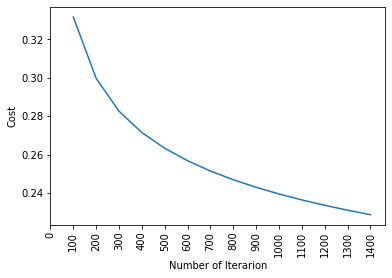

Test Accuracy: 91.04 %
Train Accuracy: 91.1 %


In [9]:
# Train model

params = logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.01, num_iterations = 1500)

In [13]:
# The weights and bias of the trained model can be saved for later use

np.savetxt("weights.csv", params['weight'], delimiter=",")
np.savetxt("bias.csv", np.asarray([params['bias'], 0]), delimiter=",")

h = h5py.File('weight.hdf5','w')
protein_complex = mat['ProteinComplex'].tolist()


In [17]:
print(x_train.shape[0])

22500


In [20]:
# Preprocess prediction images

predict_images = "prediction_images_renamed"

def predict_data():
    test_data_bat = [] 
    test_data_no_bat=[]
    for image1 in tqdm(os.listdir(predict_images)): 
        path = os.path.join(predict_images, image1)
        img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img1 = cv2.resize(img1, (image_size, image_size))
        test_data_bat.append(img1) 
    
    test_data= np.asarray(test_data_bat) 
    return test_data 

train_data = predict_data()
print("Processed training data")

100%|█████████████████████████████████████████████████████████████████████████████| 3156/3156 [00:07<00:00, 399.22it/s]


Processed training data


In [21]:
x_data = train_data
x_data = (x_data-np.min(x_data))/(np.max(x_data)-np.min(x_data))

In [22]:
x_train = x_data
number_of_train = x_train.shape[0]
x_train_flatten = x_train.reshape(number_of_train,x_train.shape[1]*x_train.shape[2])
x_train = x_train_flatten.T

In [23]:
# Make predictions

predictions = predict(params["weight"],params["bias"],x_train)

In [29]:
# Identify bat images

one = []
i = 1
for num in predictions[0]:
    if num > .5:
        one.append(i)
    i = i + 1

In [ ]:
print(one)

In [28]:
# Move bat images to different folder

for name in one:
    src = "prediction_images_renamed\\" + str(name) + ".jpg"
    dst = "bat_select\\" + str(name) + ".jpg"
    os.rename(src, dst)

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression=LogisticRegression(random_state=42)
clf = logistic_regression.fit(x_train.T,y_train.T)